<div style="text-align: right">
<pre>
Name    : Lucas Nelson 
netID   : lln2         
Section : E3           
</pre>
</div>


# FP05: Final Report
#### Table of Contents
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Data Preparation](#Data-Preparation)
    * [Visualizations](#Visualizations)
* [Inference](#Inference)
    * [Elastic Net](#Elastic-Net)
    * [statsmodel.api](#statsmodel.api)
* [Prediction](#Prediction)
    * [Null Model](#Null-Model)
    * [AdaBoost Model](#AdaBoost-Model)
    * [Gradient Boosting Model](#Gradient-Boosting-Model)
    * [Extreme Gradient Boosting Model](#Extreme-Gradient-Boosting-Model)


In [1]:
# df functionality
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# elastic net
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import linear_model as lm

# boosters
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb

In [2]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat) ** 2))

sns.set(rc = {'figure.figsize': (16, 9),
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.titlesize': 26,
              'axes.labelsize': 22})

---
## Exploratory Data Analysis
Gathering data for this project was relatively simple: select data from IPUMS Higher Educational library that could help me answer my question. Using recent college graduate survey data from 1993 to 2013, I obtained a dataset of 655,241 observations across an array of 28 features.

After finishing data wrangling and data cleaning, the final dataframe I have gathered (`highed`) contains 128,715 observations across 24 covariates, most of which are demographic (`age`, `usctz`, `gender`), educational/occupational (`bach_econ`, `high_mast`, `ocedrlp`), and economic (`urate`, `lfp`, `cpi2009c`) data.

In [3]:
highed = pd.read_pickle('/Users/lucasnelson/Desktop/University of Illinois/Junior/SP21/ECON 490/proj_final/highed_prepped_pickle.pkl')

In [4]:
highed.head()

,year,weight,age,biryr,gender,usctz,ocedrlp,salary,cpi2009c,urate,...,high_mast,high_phdd,high_prof,bach_csci,bach_ssci,bach_econ,bach_scnc,bach_engr,bach_mgmt,income_2009
0,1993,436.3180,28,1965,0,1,2,30000,1.485,6.908333,...,0,0,0,0,0,0,0,0,1,44550.0
1,1993,145.5788,28,1965,0,1,2,41000,1.485,6.908333,...,1,0,0,0,0,0,0,0,0,60885.0
2,1993,72.4603,28,1965,1,1,2,44000,1.485,6.908333,...,0,0,0,1,0,0,0,0,0,65340.0
3,1993,69.6265,28,1965,0,1,1,38000,1.485,6.908333,...,0,0,0,0,0,0,0,1,0,56430.0
4,1993,436.3180,28,1965,0,1,0,19000,1.485,6.908333,...,0,0,0,0,0,0,0,0,0,28215.0


In [5]:
highed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128715 entries, 0 to 128714
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   year         128715 non-null  int64  
 1   weight       128715 non-null  float64
 2   age          128715 non-null  int64  
 3   biryr        128715 non-null  int64  
 4   gender       128715 non-null  int64  
 5   usctz        128715 non-null  int64  
 6   ocedrlp      128715 non-null  int64  
 7   salary       128715 non-null  int64  
 8   cpi2009c     128715 non-null  float64
 9   urate        128715 non-null  float64
 10  lfp          128715 non-null  float64
 11  lfp_delta    128715 non-null  float64
 12  asian        128715 non-null  int64  
 13  minority     128715 non-null  int64  
 14  high_mast    128715 non-null  int64  
 15  high_phdd    128715 non-null  int64  
 16  high_prof    128715 non-null  int64  
 17  bach_csci    128715 non-null  int64  
 18  bach_ssci    128715 non-

In [6]:
highed.shape

(128715, 24)

#### Visualizations

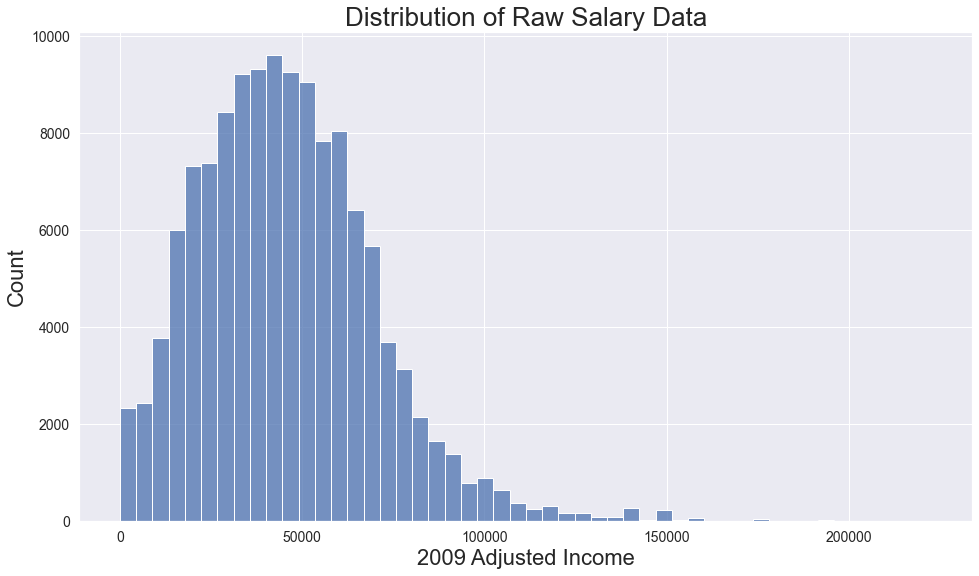

In [7]:
ax = sns.histplot(highed['income_2009'], bins=50)
ax.set(xlabel='2009 Adjusted Income', ylabel='Count')
plt.title('Distribution of Raw Salary Data')
plt.show()

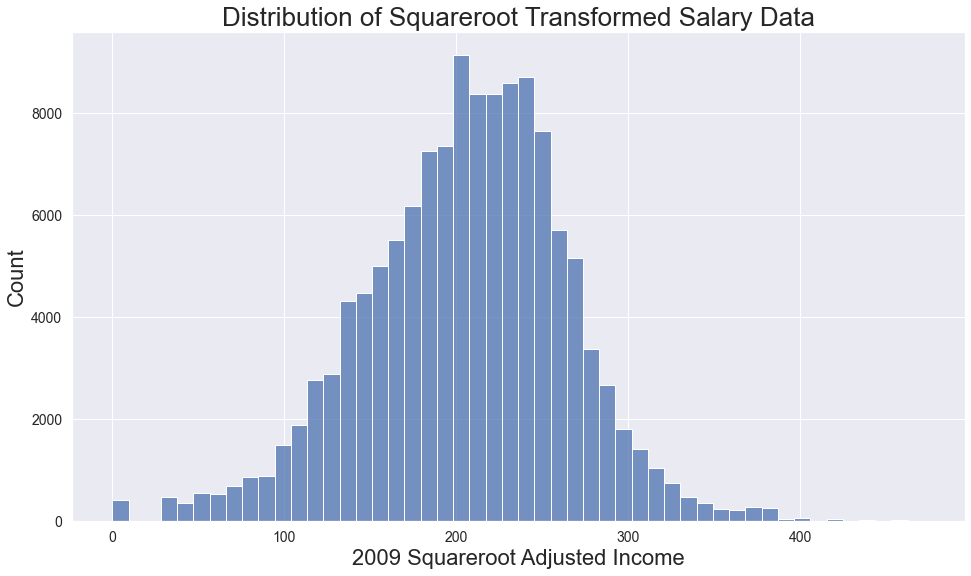

In [8]:
ax = sns.histplot(np.sqrt(highed['income_2009']), bins=50)
ax.set(xlabel='2009 Squareroot Adjusted Income', ylabel='Count')
plt.title('Distribution of Squareroot Transformed Salary Data')
plt.show()

This data set was used to take advantage of the groupings per major group that IPUMS raw data provided (as opposed to the cleaned version of the data I have since saved to the `highed` variable).

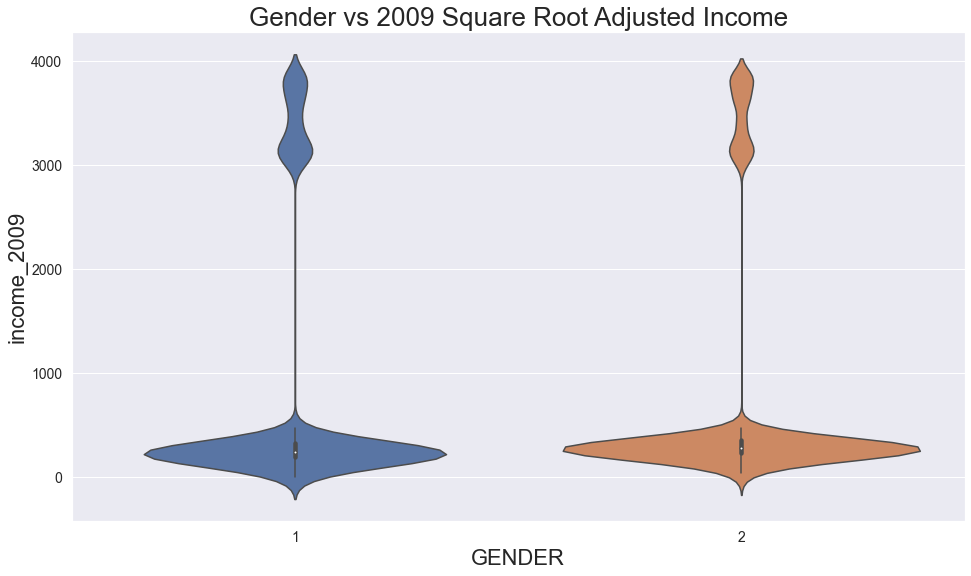

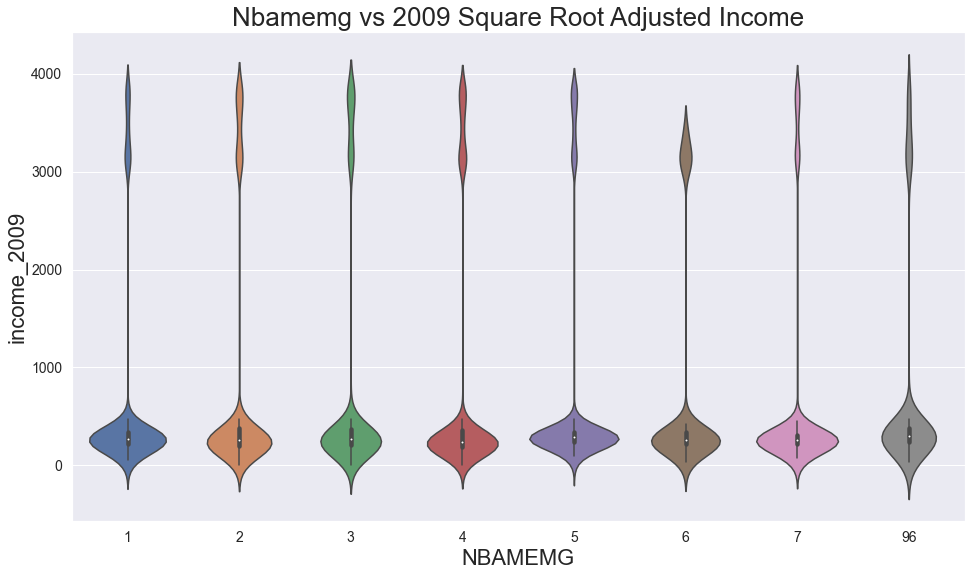

In [9]:
path1 = '/Users/lucasnelson/Desktop/University of Illinois/'
path2 = 'Junior/SP21/ECON 490/proj_final/highered_00001.csv'
highed2 = pd.read_csv(path1 + path2)
violin_plots = ['GENDER', 'NBAMEMG']
highed2['income_2009'] = highed2['SALARY'] * highed2['CPI2009C']
for i, col in enumerate(violin_plots):
    title = f'{col.title()} vs 2009 Square Root Adjusted Income'
    plt.figure(i)
    ax = sns.violinplot(x=highed2[col], y=np.sqrt(highed2['income_2009'])).set_title(title)

---
## Inference

Building a simple linear regression model using parameter grid updating and the `statsmodel.api` package (although this portion of the Inference section is not used in the final report).

In [10]:
import numpy as np

y = np.sqrt(highed['income_2009'])
x = highed.drop(columns=['income_2009', 'salary', 'cpi2009c', 'age', 'weight', 'year', 'biryr'])
x.sort_index(axis='columns', inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=2/3,
                                                    random_state=490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)

#### Elastic Net

In [11]:
fit = sm.OLS(y_train, x_train)

In [12]:
param_grid = {'alpha': 10.**np.arange(-10, -1, 1), 
              'l1_ratio': np.arange(0, 1, 0.1)}

cv_enet = lm.ElasticNet(fit_intercept = False, normalize = False,
                        random_state = 490)
grid_search = GridSearchCV(cv_enet, param_grid, cv = 5,
                         scoring = 'neg_root_mean_squared_error',
                          n_jobs = -1)
grid_search.fit(x_train_std, y_train)
best = grid_search.best_params_
best

{'alpha': 1e-05, 'l1_ratio': 0.1}

In [13]:
ols_model = sm.OLS(y_train, x_train_std)
ols_result = ols_model.fit()
fit_enet = ols_model.fit_regularized(alpha = best['alpha'], L1_wt = best['l1_ratio'])
final = sm.regression.linear_model.OLSResults(ols_model, 
                                              fit_enet.params,
                                              ols_result.normalized_cov_params)

print(final.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.185      
Dependent Variable: income_2009      AIC:                927653.6350
Date:               2021-05-14 22:03 BIC:                927822.1130
No. Observations:   85810            Log-Likelihood:     -4.6381e+05
Df Model:           17               F-statistic:        1143.      
Df Residuals:       85792            Prob (F-statistic): 0.00       
R-squared:          0.185            Scale:              2900.0     
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const       205.7552    0.1838  1119.2330  0.0000  205.3949  206.1155
asian         4.2102    0.2273    18.5242  0.0000    3.7647    4.6557
bach_csci     8.2833    0.2229    37.1675  0.0000    7.8465    8.7201
bach_econ     5.3529    0.2030    26.3755  0.00

#### statsmodel.api

In [14]:
fit_sm = sm.OLS(y_train, x_train).fit()
print(fit_sm.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.185      
Dependent Variable: income_2009      AIC:                927653.6349
Date:               2021-05-14 22:03 BIC:                927822.1129
No. Observations:   85810            Log-Likelihood:     -4.6381e+05
Df Model:           17               F-statistic:        1143.      
Df Residuals:       85792            Prob (F-statistic): 0.00       
R-squared:          0.185            Scale:              2900.0     
---------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const        328.4557   17.4791   18.7913  0.0000  294.1968  362.7146
asian         12.4678    0.6730   18.5245  0.0000   11.1486   13.7869
bach_csci     26.8657    0.7228   37.1688  0.0000   25.4490   28.2824
bach_econ     25.5637    0.9692   26.3764  0.00

---
## Prediction

Creating mean squared error scores for all prediction related models:
* null model
* AdaBoost model
* gradient boosting model
* extreme gradient boosting model

#### Null Model

In [15]:
rmse_null = rmse(np.mean(y_train), y_test)
mse_null  = rmse_null ** 2
mse_null

3539.2258748513923

#### AdaBoost Model

In [16]:
reg_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 1),
                 n_estimators = 200,
                 learning_rate = 0.5)
reg_ada.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.5, n_estimators=200)

In [17]:
%%time

param_grid = {
    'n_estimators': [15, 25, 50, 75],
    'learning_rate': 10.**np.arange(-6, -2),
}

ada_cv = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 1),
                          random_state=490)

grid_search = GridSearchCV(ada_cv, param_grid,
                          cv = 5,
                          scoring = 'r2',
                          n_jobs = -1).fit(x_train, y_train)

best = grid_search.best_params_
best

CPU times: user 7.87 s, sys: 695 ms, total: 8.56 s
Wall time: 2min 51s


{'learning_rate': 1e-06, 'n_estimators': 75}

In [18]:
reg_ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 1),
                            random_state=490,
                            n_estimators = best['n_estimators'],
                            learning_rate = best['learning_rate'])

reg_ada.fit(x_train, y_train)

mse_ada = mean_squared_error(y_test, reg_ada.predict(x_test), squared=True)
mse_ada

3221.690325370834

#### Gradient Boosting Model

In [26]:
reg_gb = GradientBoostingRegressor(n_estimators = 200,
                                  max_depth = 2,
                                  learning_rate = 0.1,
                                  validation_fraction = 1/8,
                                  n_iter_no_change = 4,
                                  verbose = 2,
                                  random_state = 499)

reg_gb.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        3474.2123           27.27s
         2        3406.6775           27.63s
         3        3350.6265           25.29s
         4        3303.4743           23.46s
         5        3263.6779           23.73s
         6        3230.1873           23.42s
         7        3197.6995           22.30s
         8        3171.8428           21.75s
         9        3149.7973           20.92s
        10        3127.9233           20.84s
        11        3110.4985           20.87s
        12        3094.1886           20.29s
        13        3080.3467           19.85s
        14        3066.5330           19.75s
        15        3054.6436           19.40s
        16        3043.6150           18.98s
        17        3033.0609           18.95s
        18        3023.4924           18.77s
        19        3015.0167           18.48s
        20        3006.8353           18.45s
        21        2999.7097           18.16s
        2

       185        2802.7512            1.41s
       186        2802.5714            1.31s
       187        2802.3457            1.22s
       188        2802.2075            1.12s
       189        2802.0852            1.03s
       190        2801.6430            0.93s
       191        2801.5695            0.84s
       192        2801.5118            0.75s
       193        2801.2578            0.65s
       194        2801.1631            0.56s
       195        2801.0544            0.47s
       196        2800.6983            0.37s
       197        2800.6300            0.28s
       198        2800.4274            0.19s
       199        2800.3007            0.09s
       200        2800.1611            0.00s


GradientBoostingRegressor(max_depth=2, n_estimators=200, n_iter_no_change=4,
                          random_state=499, validation_fraction=0.125,
                          verbose=2)

In [27]:
from sklearn.metrics import mean_squared_error

mse_gb = mean_squared_error(y_test, reg_gb.predict(x_test), squared=True)
mse_gb

2789.4586749017126

#### Extreme Gradient Boosting Model

In [21]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train,
                                                                            train_size = 4/5,
                                                                            random_state = 490)

In [22]:
reg_xgb = xgb.XGBRegressor(n_estimators = 200,
                          max_depth = 2,
                          learning_rate = 0.1,
                          random_state = 490)

reg_xgb.fit(x_train_train, y_train_train,
           eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 4)

[0]	validation_0-rmse:193.97310
[1]	validation_0-rmse:176.26325
[2]	validation_0-rmse:160.49913
[3]	validation_0-rmse:146.46492
[4]	validation_0-rmse:134.02322
[5]	validation_0-rmse:123.02196
[6]	validation_0-rmse:113.27793
[7]	validation_0-rmse:104.73705
[8]	validation_0-rmse:97.27106
[9]	validation_0-rmse:90.71945
[10]	validation_0-rmse:85.03958
[11]	validation_0-rmse:80.14595
[12]	validation_0-rmse:75.93383
[13]	validation_0-rmse:72.33122
[14]	validation_0-rmse:69.26791
[15]	validation_0-rmse:66.65652
[16]	validation_0-rmse:64.45917
[17]	validation_0-rmse:62.62433
[18]	validation_0-rmse:61.07471
[19]	validation_0-rmse:59.78712
[20]	validation_0-rmse:58.70433
[21]	validation_0-rmse:57.79762
[22]	validation_0-rmse:57.05013
[23]	validation_0-rmse:56.42783
[24]	validation_0-rmse:55.90191
[25]	validation_0-rmse:55.47966
[26]	validation_0-rmse:55.11910
[27]	validation_0-rmse:54.80412
[28]	validation_0-rmse:54.55292
[29]	validation_0-rmse:54.33919
[30]	validation_0-rmse:54.16164
[31]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=490,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
mse_xgb = mean_squared_error(y_test, reg_xgb.predict(x_test), squared=True)
mse_xgb

2788.800799185251